/tmp/ipython-input-612956968.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hardest_keys.index, y=hardest_keys['error_rate'], ax=axes[1, 1], palette='Reds_r')


Goal 130 WPM: Session #31919 on 2026-05-27
Goal 99% Acc: Session #30659 on 2026-05-06


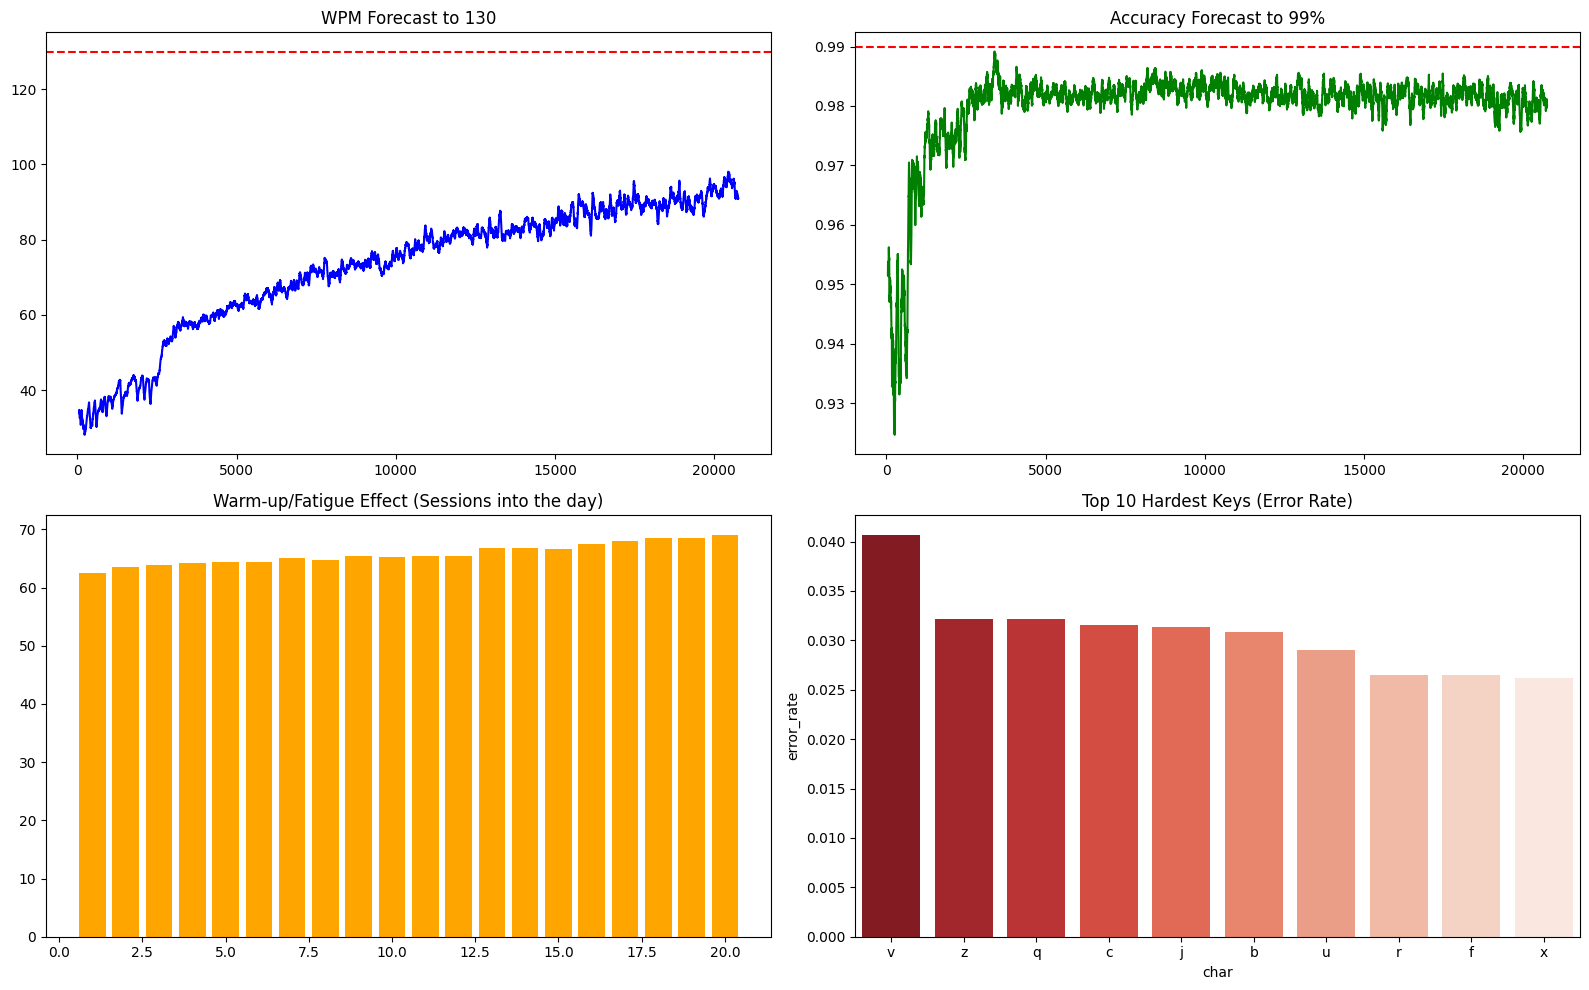

In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import timedelta

# 1. LOAD AND PREPROCESS DATA
def load_and_enrich_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    session_rows = []
    char_rows = []

    for session in data:
        ts = pd.to_datetime(session['timeStamp'])

        # Aggregate histogram for accuracy and char-level stats
        hits, misses = 0, 0
        for entry in session.get('histogram', []):
            hits += entry['hitCount']
            misses += entry['missCount']
            char_rows.append({
                'char': chr(entry['codePoint']),
                'hits': entry['hitCount'],
                'misses': entry['missCount'],
                'time': entry['timeToType']
            })

        acc = hits / (hits + misses) if (hits + misses) > 0 else 0

        session_rows.append({
            'timestamp': ts,
            'date': ts.date(),
            'wpm': session['speed'] / 5, # Convert CPM to WPM
            'accuracy': acc
        })

    df = pd.DataFrame(session_rows).sort_values('timestamp').reset_index(drop=True)
    df['session_id'] = df.index + 1

    # Calculate Fatigue: What number session is this for today?
    df['session_of_day'] = df.groupby('date').cumcount() + 1

    # Volatility (Rolling Consistency)
    df['wpm_volatility'] = df['wpm'].rolling(window=20).std()

    return df, pd.DataFrame(char_rows)

# 2. ANALYSIS & FORECASTING
def forecast(df, column, target):
    model = LinearRegression().fit(df[['session_id']].values, df[column].values)
    slope = model.coef_[0]
    target_session = (target - model.intercept_) / slope

    days_elapsed = (df['timestamp'].max() - df['timestamp'].min()).days
    sessions_per_day = len(df) / max(days_elapsed, 1)
    target_date = df['timestamp'].max() + timedelta(days=(target_session - len(df)) / sessions_per_day)

    return int(target_session), target_date

# 3. RUN ENGINE
df, df_chars = load_and_enrich_data('typing-data.json')
wpm_sess, wpm_date = forecast(df, 'wpm', 130)
acc_sess, acc_date = forecast(df, 'accuracy', 0.99)

# Character Analysis
char_agg = df_chars.groupby('char').agg({'hits': 'sum', 'misses': 'sum'})
char_agg['error_rate'] = char_agg['misses'] / (char_agg['hits'] + char_agg['misses'])
hardest_keys = char_agg.sort_values('error_rate', ascending=False).head(10)

# 4. VISUALIZE DASHBOARD
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Speed Forecast
axes[0, 0].plot(df['session_id'], df['wpm'].rolling(50).mean(), color='blue')
axes[0, 0].axhline(130, color='red', linestyle='--')
axes[0, 0].set_title('WPM Forecast to 130')

# Accuracy Forecast
axes[0, 1].plot(df['session_id'], df['accuracy'].rolling(50).mean(), color='green')
axes[0, 1].axhline(0.99, color='red', linestyle='--')
axes[0, 1].set_title('Accuracy Forecast to 99%')

# Fatigue Analysis
fatigue = df.groupby('session_of_day')['wpm'].mean().head(20)
axes[1, 0].bar(fatigue.index, fatigue.values, color='orange')
axes[1, 0].set_title('Warm-up/Fatigue Effect (Sessions into the day)')

# Character Bottlenecks
sns.barplot(x=hardest_keys.index, y=hardest_keys['error_rate'], ax=axes[1, 1], palette='Reds_r')
axes[1, 1].set_title('Top 10 Hardest Keys (Error Rate)')

plt.tight_layout()
plt.savefig('comprehensive_typing_dashboard.png')

print(f"Goal 130 WPM: Session #{wpm_sess} on {wpm_date.date()}")
print(f"Goal 99% Acc: Session #{acc_sess} on {acc_date.date()}")